# Model development for anomaly detection

Generally, what we are trying to do is to estimate the density of the "normal" - "good" scenario

Two approaches were followed

- Estimating the density by identifying mean and covariance of the "normal/good" distribution. Then using Mahalanobis distance to see how far a data instance is from a distribution.
- Kernel based density estimation

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
# Append library path
lib_path = os.path.join(os.path.dirname(os.getcwd()), "lib")
sys.path.append(lib_path)
import numpy as np
import data_prep, feature_extraction,model_evaluations
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# Loading the data

Adding all required files

In [2]:
# Base data directory location
data_loc = os.path.join(os.path.dirname(os.getcwd()), "DATA")

# file name
file_names = {
    0: "machine_ON_no-ref_start-error_1.csv",  # Machine turned ON, and the parameter switch enable error
    1: "machine_ON_no-ref_start-error_2.csv",
    2: "machine_ON_no-ref_start-error_3.csv",
    3: "machine_ON_no-ref_start-error_4.csv",
    4: "machine_ON_ref_no-error_1.csv",  # Machine ON referenced and no-error idling
    5: "machine_ON_ref_no-error_2.csv",  # Machine ON referenced and no-error idling
    6: "machine_ON_ref_no-error_3.csv",
    7: "machine_ON_ref_no-error_4.csv",
    8: "machine_ON_ref_no-error_5.csv",
    9: "machine_ON_ref_no-error_6.csv",
    10: "machine_ON_ref_no-error_7.csv",
    11: "machine_ON_ref_no-error_8.csv",
    12: "machine_ON_ref_overtravel-error_x_neg_1.csv",  # Machine ON referenced and Overtravel for X negative
    13: "machine_ON_ref_overtravel-error_x_pos_1.csv",  # Machine ON referenced and Overtravel for X positive
    14: "machine_ON_no-ref_overtravel-error_x_neg_1.csv",  # Machine ON not-referenced and Overtravel for X negative
    15: "machine_ON_no-ref_overtravel-error_x_pos_1.csv", # Machine ON not-referenced and Overtravel for X positive
    16: "machine_ON_ref_overtravel-error_x_neg_axes-extreme_1.csv", # Reference and overtravel in X
    17: "machine_ON_ref_overtravel-error_x_neg_axes-extreme_2.csv", # Referenced and overtravel in X
    18: "machine_ON_ref_overtravel-error_x_pos_axes-extreme_1.csv", # Referenced and overtravel in X
    19: "machine_ON_ref_overtravel-error_y_neg_axes-extreme_1.csv",  # Machine ON referenced and Overtravel for Y negative
    20: "machine_ON_ref_overtravel-error_y_neg_1.csv", # Machine and ON referenced and Overtravel in Y
    21: "machine_ON_ref_overtravel-error_y_pos_1.csv",  # Machine ON referenced and Overtravel for Y positive
    22: "machine_ON_ref_overtravel-error_z_neg_1.csv",  # Machine ON referenced and Overtravel for Z negative
    23: "machine_ON_ref_overtravel-error_z_pos_1.csv",  # Machine ON referenced and Overtravel for Z positive
}

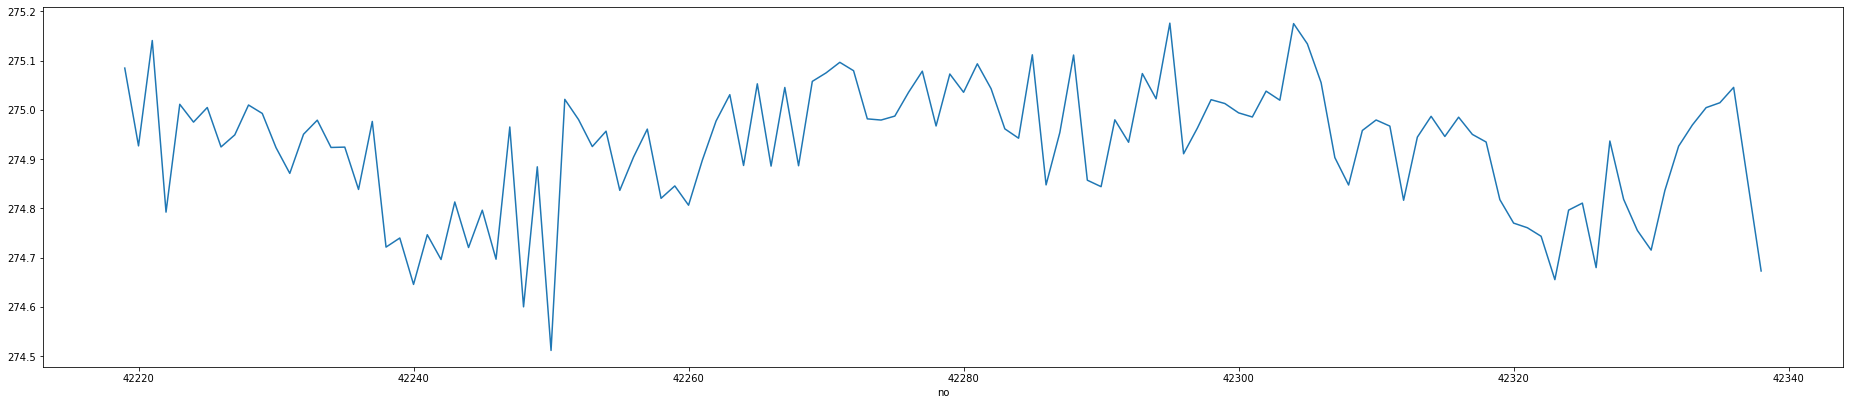

In [3]:
# load the data
index = 5
df = pd.read_csv(os.path.join(data_loc, file_names[index]), header="infer", index_col="no")
fig = plt.figure(figsize=(25, 5))
axs = fig.add_axes([0, 0, 1, 1])
df["PowerSum"][-120:].plot(ax=axs)

# Data preparation

- Segment
- Identify the anomalous and non-anomalous class
- Feature extraction
- Generate training data

## Segmentation

In [4]:
segment_secs = 60
wavelet_nperseg = 15

In [5]:
# Dont choose "no" and "sample_time" as they will be added later to the beginning
# Chosen - Three different power components for three phases
chosen_cols = ["Power1", "Power2", "Power3", "PowerReac1", "PowerReac2", "PowerReac3", "PowerApp1", "PowerApp2", "PowerApp3"]
segmented_data = {}
for index, file_name in file_names.items():
    path = os.path.join(data_loc, file_name)
    temp = data_prep.segment_data(file_name=path, col_names=chosen_cols, segment_secs=segment_secs)
    # Remove the sample_time col
    temp = temp[:, 1:, :]
    segmented_data[file_name] =  temp

In [6]:
# Print to ensure that segmentation is successful
for file_name in segmented_data.keys():

    sys.stdout.write(f"For the file-{file_name} the shape-{segmented_data[file_name].shape}\n")

For the file-machine_ON_no-ref_start-error_1.csv the shape-(60, 9, 19)
For the file-machine_ON_no-ref_start-error_2.csv the shape-(60, 9, 106)
For the file-machine_ON_no-ref_start-error_3.csv the shape-(60, 9, 859)
For the file-machine_ON_no-ref_start-error_4.csv the shape-(60, 9, 5054)
For the file-machine_ON_ref_no-error_1.csv the shape-(60, 9, 243)
For the file-machine_ON_ref_no-error_2.csv the shape-(60, 9, 705)
For the file-machine_ON_ref_no-error_3.csv the shape-(60, 9, 162)
For the file-machine_ON_ref_no-error_4.csv the shape-(60, 9, 1129)
For the file-machine_ON_ref_no-error_5.csv the shape-(60, 9, 338)
For the file-machine_ON_ref_no-error_6.csv the shape-(60, 9, 1436)
For the file-machine_ON_ref_no-error_7.csv the shape-(60, 9, 4926)
For the file-machine_ON_ref_no-error_8.csv the shape-(60, 9, 2052)
For the file-machine_ON_ref_overtravel-error_x_neg_1.csv the shape-(60, 9, 692)
For the file-machine_ON_ref_overtravel-error_x_pos_1.csv the shape-(60, 9, 295)
For the file-machine

## Determine classes

- Anomaly - 0
- Not Anomaly - 1


In [7]:
# Associations between the classes and the files in this study
class_file_association = {
    "on-ref": ["machine_ON_ref_no-error_1.csv", "machine_ON_ref_no-error_2.csv", "machine_ON_ref_no-error_3.csv", "machine_ON_ref_no-error_4.csv", "machine_ON_ref_no-error_5.csv", "machine_ON_ref_no-error_6.csv", "machine_ON_ref_no-error_7.csv", "machine_ON_ref_no-error_8.csv"],

    "on-noref-error": ["machine_ON_no-ref_start-error_1.csv", "machine_ON_no-ref_start-error_2.csv", "machine_ON_no-ref_start-error_3.csv", "machine_ON_no-ref_start-error_4.csv"],

    "overtravel-x": ["machine_ON_ref_overtravel-error_x_neg_1.csv", "machine_ON_ref_overtravel-error_x_pos_1.csv", "machine_ON_no-ref_overtravel-error_x_neg_1.csv", "machine_ON_no-ref_overtravel-error_x_pos_1.csv", "machine_ON_ref_overtravel-error_x_neg_axes-extreme_1.csv",
    "machine_ON_ref_overtravel-error_x_neg_axes-extreme_2.csv", "machine_ON_ref_overtravel-error_x_pos_axes-extreme_1.csv"],

    "overtravel-y": ["machine_ON_ref_overtravel-error_y_neg_1.csv", "machine_ON_ref_overtravel-error_y_pos_1.csv",
                    "machine_ON_ref_overtravel-error_y_neg_axes-extreme_1.csv"],
    "overtravel-z": ["machine_ON_ref_overtravel-error_z_neg_1.csv", "machine_ON_ref_overtravel-error_z_pos_1.csv"],
}

In [8]:
# Okay
class_segmented_data = {}
for class_instance in class_file_association.keys():
    for index, file_name in enumerate(class_file_association[class_instance]):

        if index == 0:
            class_segmented_data[class_instance] = segmented_data[file_name]
        else:
            class_segmented_data[class_instance] = np.append(class_segmented_data[class_instance], segmented_data[file_name], axis=-1)

In [9]:
# Reshape the data appropriately
for class_instance in class_segmented_data.keys():
    class_segmented_data[class_instance] = np.transpose(class_segmented_data[class_instance], (2, 1, 0))

In [10]:
# Print to ensure that the files have been loaded correctly
for class_instance in class_segmented_data.keys():

    sys.stdout.write(f"The class-{class_instance} has the shape-{class_segmented_data[class_instance].shape}\n")

The class-on-ref has the shape-(10991, 9, 60)
The class-on-noref-error has the shape-(6038, 9, 60)
The class-overtravel-x has the shape-(3469, 9, 60)
The class-overtravel-y has the shape-(1397, 9, 60)
The class-overtravel-z has the shape-(1461, 9, 60)


# Feature Extraction

- Extract all the features

In [11]:
class_dataset_features = {}
for class_instance in class_segmented_data.keys():
    dataset_features = []
    for row in class_segmented_data[class_instance]:
        computed_features = []
        for col in row:
            freq_args = [{"axis": 0}, {"axis": 0}, {"axis": 0, "nperseg": wavelet_nperseg}]
            freq_time_args = [{"wavelet": "db1"}, {"wavelet": "db1"}, {"wavelet": "db1"}]
            # Extract all features
            computed_features += feature_extraction.compute_all_features(col, freq_args=freq_args, freq_time_args=freq_time_args)

        # Append to a list
        dataset_features.append(computed_features)

    # Add to class instance
    class_dataset_features[class_instance] = np.array(dataset_features)

In [12]:
sys.stdout.write("After feature extraction process\n\n")
for class_instance in class_dataset_features.keys():

    sys.stdout.write(f'For the class-{class_instance} , the extracted features has the shape={class_dataset_features[class_instance].shape}\n')

After feature extraction process

For the class-on-ref , the extracted features has the shape=(10991, 153)
For the class-on-noref-error , the extracted features has the shape=(6038, 153)
For the class-overtravel-x , the extracted features has the shape=(3469, 153)
For the class-overtravel-y , the extracted features has the shape=(1397, 153)
For the class-overtravel-z , the extracted features has the shape=(1461, 153)


# Model development

- Estimating the mean and covariance of non-anomalous condition
- Using kernels to estimate density

In [13]:
# Get the train and testing datasets
X_train = class_dataset_features["on-ref"]

# Split it by different know classes
X_test = {}
for class_name in class_dataset_features.keys():
    if class_name != "on-ref":
        X_test[class_name] = class_dataset_features[class_name]

## PCA and Mahalanobis distance Anomaly detection

- Reduce the dimension using PCA
- Use mahalanobis distance as the metric to identify if things go out of distribution



### Estimating mean and covariance

In [14]:
# Define some functions and metrics
def compute_cov_invcov(X):
    covariance = np.cov(X, rowvar=False)
    inv_covariance = np.linalg.inv(covariance)

    return covariance, inv_covariance


def distance_metric(X, mean, inv_cov, metric_type="mahalanobis"):

    assert len(X.shape) == 2, "The X must be an array and not a vector"

    if metric_type == "mahalanobis":
        # Difference
        difference = (X - mean).T

        return np.sqrt(difference.T.dot(inv_cov).dot(difference))

    else:
        raise Exception("Metric not defined")


def distance_distribution(X, mean, inv_cov, metric_type="mahalanobis"):

    dd = []
    for index, item in enumerate(X):
        distance = distance_metric(item[np.newaxis, :], mean, inv_cov, metric_type=metric_type).squeeze()
        dd.append(distance.tolist())

    return dd

In [15]:
# Apply PCA
pca = PCA(n_components=140, svd_solver="full")

# Transform data
X_train_PCA = pca.fit_transform(X_train)

X_test_PCA = {}
for class_name in X_test:
    X_test_PCA[class_name] = pca.transform(X_test[class_name])

In [16]:
# Items to be saved
# Compute the covariance
cov, inv_cov = compute_cov_invcov(X_train_PCA)
# Compute mean
mean = np.mean(X_train_PCA, axis=0)

### Mahalanobis distance distribution
- Distance from the center of the distribution for the non-anomalous data

In [17]:
# Compute the distance for both Train and Test
distances_training = distance_distribution(X_train_PCA, mean, inv_cov)
distances_testing = {}
for class_name in X_test_PCA.keys():
    distances_testing[class_name] = distance_distribution(X_test_PCA[class_name], mean, inv_cov)

# Merged dictionaries
distributions = copy.deepcopy(distances_testing)
distributions["normal"] = distances_training

Text(0.5, 1.0, 'Mahalanobis distance distribution')

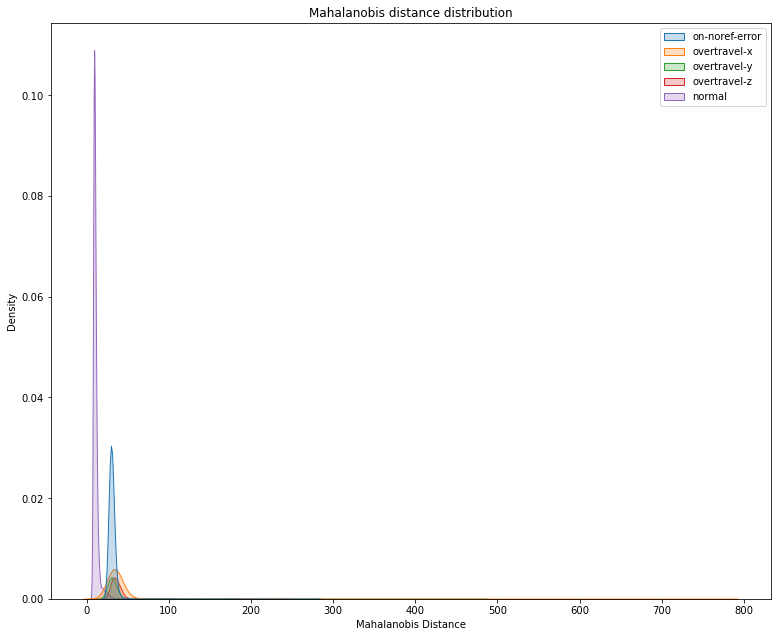

In [18]:
# Creating figures
fig = plt.figure(figsize=(10, 8))
axs = fig.add_axes([0, 0, 1, 1])

# Plotting the distributions
dist_plot = sns.kdeplot(data = distributions, fill=True, ax=axs)
# Setting labels and properties
dist_plot.set_xlabel("Mahalanobis Distance")
dist_plot.set_title("Mahalanobis distance distribution")

In [19]:
# Plotting the combined anomalous class
distances_testing_combined = []
for class_name in distances_testing.keys():
    distances_testing_combined += distances_testing[class_name]
# Get the distributions
distributions = dict()
distributions["normal"] = distances_training
distributions["anomaly"] = distances_testing_combined

Text(0.5, 1.0, 'Mahalanobis distance distribution')

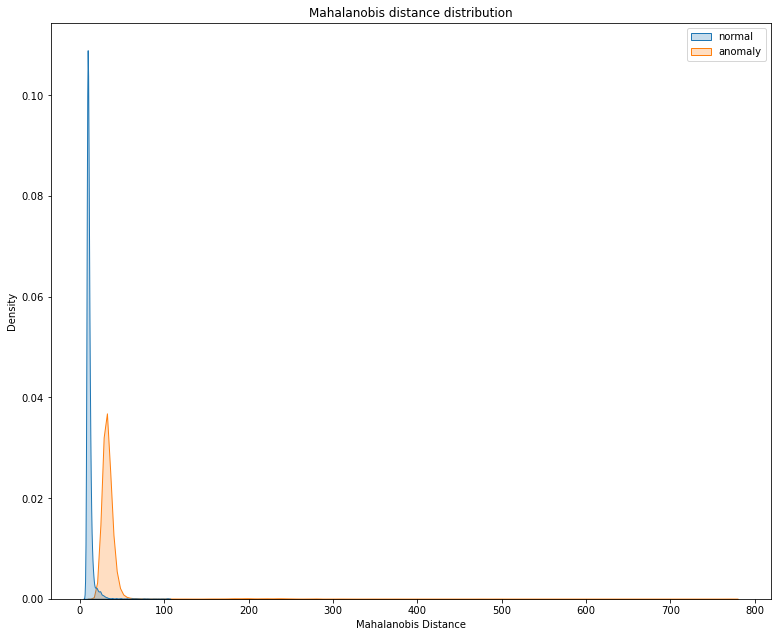

In [20]:
# Creating figures
fig = plt.figure(figsize=(10, 8))
axs = fig.add_axes([0, 0, 1, 1])

# Plotting the distributions
dist_plot = sns.kdeplot(data = distributions, fill=True, ax=axs)
# Setting labels and properties
dist_plot.set_xlabel("Mahalanobis Distance")
dist_plot.set_title("Mahalanobis distance distribution")

### Determine Threshold

- Generally 3$\sigma$ from the mean

In [21]:
# Threshold determination function
def compute_threshold(dist, level):
    # Compute mean and STD
    normal_distances_mean = np.mean(dist)
    normal_distances_std = np.std(dist)

    return normal_distances_mean + (level * normal_distances_std)

In [22]:
# Use the PCA to reduce dimension
pca = PCA(n_components=140, svd_solver="full")

# Transform data
X_train_PCA = pca.fit_transform(X_train)

X_test_PCA = {}
for class_name in X_test:
    X_test_PCA[class_name] = pca.transform(X_test[class_name])


### Test the threshold

- Apply and compare performance

In [23]:
# Initialize evaluations
kwargs = {
    "accuracy_score": {},
    "balanced_accuracy_score": {},
    "f1_score": {},
    "recall_score": {},
    "precision_score": {},

}

# Dataset after PCA application
threshold_levels = [1, 2, 3, 4]
evaluations = {}
for threshold_level in threshold_levels:
    # Compute threshold
    threshold = compute_threshold(distances_training, threshold_level)

    # Prediction
    temp = np.array(distances_training)
    y_pred1 = np.where(temp < threshold, 0, 1)
    y_true1 = np.repeat(0, len(distances_training))
    temp = np.array(distances_testing_combined)
    y_pred2 = np.where(distances_testing_combined < threshold, 0, 1)
    y_true2 = np.repeat(1, len(distances_testing_combined))

    # Performance metrics
    model_eval = model_evaluations.ModelEval()
    evaluations[round(threshold, 2)] = copy.deepcopy(model_eval.compute_all_metrics(np.concatenate([y_true1, y_true2]), np.concatenate([y_pred1, y_pred2]), kwargs=kwargs))

# Get it as dataFrame
evaluations = pd.DataFrame(evaluations)
evaluations = evaluations.T.copy()

### Plotting results

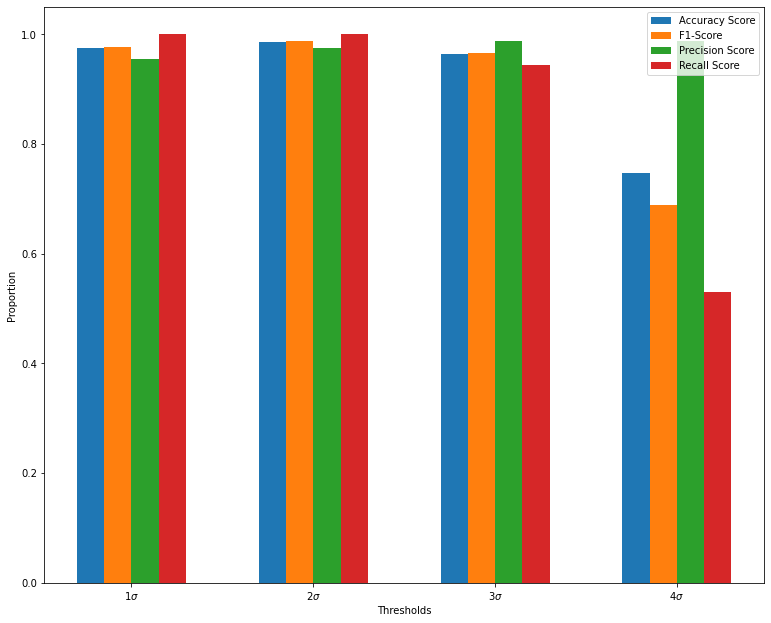

In [24]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0, 0, 1, 1])

# Evaluation labels
labels = ["1$\sigma$", "2$\sigma$", "3$\sigma$", "4$\sigma$"]
width = 0.15
x = np.arange(4)

# Plotting
ax.bar(x - 0.225, evaluations["accuracy_score"], width, label="Accuracy Score")
ax.bar(x - 0.075, evaluations["f1_score"], width, label="F1-Score")
ax.bar(x + 0.075, evaluations["precision_score"], width, label="Precision Score")
ax.bar(x + 0.225, evaluations["recall_score"], width, label="Recall Score")

ax.set_xlabel("Thresholds")
ax.set_ylabel("Proportion")
ax.set_title("")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

## Kernel density estimation

- Estimate the density of the normal class
- Score and evaluate to determine if there is an anomaly in the data

In [25]:
# Estimate the density
kde = KernelDensity(kernel="gaussian")
# Fit the training data
kde.fit(X_train_PCA)

# Get scores
normal_scores = kde.score_samples(X_train_PCA)
anomaly_scores = {}
for class_name in X_test_PCA.keys():
    anomaly_scores[class_name] = kde.score_samples(X_test_PCA[class_name])

### Determine threshold

In [26]:
normal_scores.shape

(10991,)

In [27]:
# Lower end - Anything lower than this is an anomaly
threshold = np.quantile(normal_scores, q=0.02)

### Test the threshold

In [28]:
# Initialize evaluations
kwargs = {
    "accuracy_score": {},
    "balanced_accuracy_score": {},
    "f1_score": {},
    "recall_score": {},
    "precision_score": {},

}

# Combine all anomaly classes
for index, class_name in enumerate(anomaly_scores.keys()):
    if index == 0:
        temp = anomaly_scores[class_name]
    else:
        temp = np.concatenate([temp, anomaly_scores[class_name]])

# Prediction
y_pred1 = np.where(normal_scores < threshold, 1, 0)
y_true1 = np.repeat(0, normal_scores.shape[0])
y_pred2 = np.where(temp < threshold, 1, 0)
y_true2 = np.repeat(1, temp.shape[0])

# Performance metrics
model_eval = model_evaluations.ModelEval()
evaluations = model_eval.compute_all_metrics(np.concatenate([y_true1, y_true2]), np.concatenate([y_pred1, y_pred2]), kwargs=kwargs)


In [29]:
# Print out the evaluations
evaluations

{'accuracy_score': 1.0,
 'balanced_accuracy_score': 1.0,
 'f1_score': 1.0,
 'recall_score': 1.0,
 'precision_score': 1.0}

### Inference
- The performance was 100%. Needs to be tested with more normal scenarios

## Isolation Forest - Outlier Estimation

- Using this because of High Dimensionality of the input dataset
- No PCA is applied here

In [44]:
# Fit only on the good state of the machine
iso_forest = IsolationForest(n_estimators=100, bootstrap=True)
# Fit the training dataset
iso_forest.fit(X_train)

IsolationForest(bootstrap=True)

### Prediction

- Calling the predict method

In [45]:
# Predicting the training data again
y_pred1 = iso_forest.predict(X_train)
y_true1 = np.repeat(0, normal_scores.shape[0])
temp_count = 0
for index, class_name in enumerate(X_test.keys()):
    predictions = iso_forest.predict(X_test[class_name])
    if index == 0:
        y_pred2 = predictions
        temp_count += predictions.shape[0]
    else:
        y_pred2 = np.concatenate([y_pred2, predictions])
        temp_count += predictions.shape[0]
y_true2 = np.repeat(1, temp_count)

# Replace -1/+1
y_pred1 = np.where(y_pred1 == 1, 0, 1)
y_pred2 = np.where(y_pred2 == 1, 0, 1)

# Evaluation
# Performance metrics
model_eval = model_evaluations.ModelEval()
evaluations = model_eval.compute_all_metrics(np.concatenate([y_true1, y_true2]), np.concatenate([y_pred1, y_pred2]), kwargs=kwargs)

In [46]:
# Print the evaluations
evaluations

{'accuracy_score': 0.9550436718616201,
 'balanced_accuracy_score': 0.9538007110401654,
 'f1_score': 0.9582670906200318,
 'recall_score': 0.9749292357460574,
 'precision_score': 0.9421649081672528}

Performed reasonable well. Not as good as the Kernal Density Estimation. But reasonable

## SVM - One Class

- With Non-Linear RBF Kernel